# J2_VOP benchmark 

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Initial-value-problem:-VOP-formulation-of-$J_2$-KS-equation">
              Initial value problem: VOP formulation of $J_2$-KS equation</a></li>

<li><a href="#Work-precision-diagrams">
             Work-precision diagrams</a></li>

</ul>  

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
using DiffEqDevTools,BenchmarkTools
using OrdinaryDiffEq
using JLD2, FileIO
using NBInclude

In [2]:
PATH_SRC="../src/"

include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   

##### <a href="#top">Back to the top</a>

## Initial value problem: VOP formulation of $J_2$-KS equation


In [3]:
PATH_ODES="../ODEProblems/"

@nbinclude(string(PATH_ODES,"J2_VOP.ipynb"));

In [4]:
q0 = [0., 37947.73745727695, 0.]
v0 = [3.297676220718193,0., 0.8244190551795483]
μ = 398600.8
h = μ/norm(q0) - 0.5*dot(v0,v0) -  V(q0) 
ω = sqrt(h/2)

u0 = χ(q0)
V0 = vcat(v0,[0.])
w0 = 0.5*L(u0)' * V0
r0 = norm(q0)

dim=length(size(u0))

# Konprobazioa:
(norm(L(u0)*u0 - vcat(q0,[0.])), norm(r0*V0 - 2* L(u0) * w0))

(0.0, 2.9999541770795335e-11)

In [5]:
Ifcn(u0,w0)

0.0

### VOP formulation




In [6]:
α0 = u0
β0 = w0
U0 = vcat(α0, β0)
μ = 398600.8
h = μ/norm(q0) - 0.5*dot(v0,v0) -  V(q0)
ω = sqrt(h/2)
C = 1.7554962315534863e10
p = [C, ω, μ];

### Integration parameters

In [7]:
s=8

t0 = 0.
sasi_periodo = 2*π/ω
sasi_periodo = 6/ω
dt = sasi_periodo/5
tF = 20000*sasi_periodo
tF = 2000*sasi_periodo


n = 1000
#n = 5

m = convert(Int64,ceil(abs(tF-t0)/(n*dt)))
m=100
n = convert(Int64,ceil(abs(tF-t0)/(m*dt))) # Number of macro-steps (Output is saved for n+1 time values)
dt = (tF-t0)/(n*m)
println("dt = $dt, n=$n, m=$m")

prob = ODEProblem(J2VOPODE!, U0, (t0,tF), p)

tspan_B=(BigFloat(t0),BigFloat(tF))
U0_B=BigFloat.(U0)
p_B=BigFloat.(p)

prob_B = ODEProblem(J2VOPODE!, U0_B, tspan_B, p_B);

dt = 0.7805603175486533, n=100, m=100


##### <a href="#top">Back to the top</a>

## Work-precision diagrams

### Test-Solution

In [8]:
#sol =solve(prob_B,Vern9(),save_everystep=false, abstol=1e-16,reltol=1e-16)
#@save "./Data/VOP_sol_T2000.jld2" sol
#test_sol = TestSolution(sol)

@load "./Data/VOP_sol_T2000.jld2" sol
test_sol = TestSolution(sol)
final_state=sol.u[end]

E0=J2VOPEnergy(sol.u[1],p_B,sol.t[1])
(Float32(sol.t[end]),Float32(J2VOPEnergy(sol.u[end],p_B,sol.t[end])/E0-1))

(7805.603f0, -2.9736134f-17)

### Integrations

In [9]:
tols=abstols=reltols=[1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]

dts8= [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1., 1.05, 1.1]
dts4=dts8/2
dtsVern=dts4;

In [10]:
nruns=1000

wp1=launch_method_tests(Vern9(), final_state, prob, tols, nruns=nruns)
wp11=launch_method_tests(Vern9(), final_state, prob, dtsVern, adaptive=false, nruns=nruns)

s=8
wp2=launch_IRKGL_simd_tests(final_state, prob, dim, s, dts8,
                            initial_interp=0, partitioned=false, nruns=nruns)
#
s=4
wp3=launch_IRKGL_simd_tests(final_state, prob, dim, s, dts4,
                            initial_interp=0, partitioned=false, nruns=nruns);

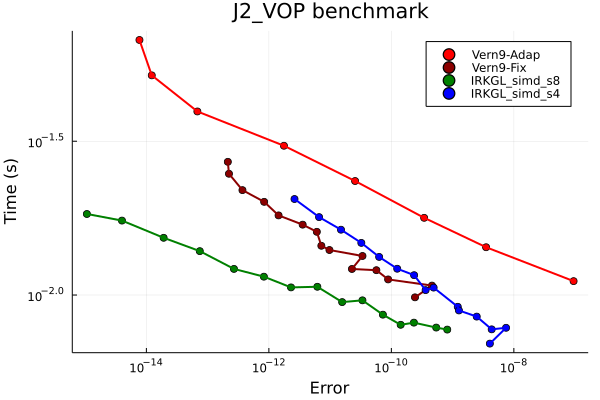

In [11]:
plot(title="J2_VOP benchmark",xlabel="Error", ylabel="Time (s)")
# 
plot!(wp1.errors, wp1.times, seriestype=:scatter, scale=:log10, label="Vern9-Adap",color="red")
plot!(wp1.errors, wp1.times, scale=:log10, label="", lw=2, color="red")
#
plot!(wp11.errors, wp11.times, seriestype=:scatter, scale=:log10, label="Vern9-Fix",color="Darkred")
plot!(wp11.errors, wp11.times, scale=:log10, label="", lw=2, color="Darkred")

#
plot!(wp2.errors, wp2.times, seriestype=:scatter, scale=:log10, label="IRKGL_simd_s8",color="green")
plot!(wp2.errors, wp2.times, scale=:log10, label="", lw=2, color="green")
#
plot!(wp3.errors, wp3.times, seriestype=:scatter, scale=:log10, label="IRKGL_simd_s4",color="blue")
plot!(wp3.errors, wp3.times, scale=:log10, label="", lw=2, color="blue")
#